<a href="https://colab.research.google.com/github/evgebrtwjhr/Anubis-7.0/blob/main/AI_TXT_SRT_transcription_with_all_languages_translation_by_Yuval_Avidani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Transcriber by Yuval Avidani - יובל אבידני**

**Please support with Beer: https://linktree.com/hackit.co.il**

**IMPORTANT: GPU is required for this notebook to work! This means a Pro Account is crucial. Otherwise the runtime will not work properly!**

**V100/A100 GPU IS PREFFERED FOR USING THIS NOTEBOOK! T4 should also be supported but it is more common that working on T4 will lead the notebook to CRASH DURING THE RUN  AND GETTING 'CUDA MEMORY ERROR' MESSAGES**

This notebook has the followings capabilities:

1. Select between YouTube URL and Media Files Upload
2. Select the language of the original language in the media file / YouTube URL
3. YouTube Videos are downloaded and convereted to MP3
4. File size check is made to adhere to Whisper's file limit size of 25MB
5. If the file is larger, the notebook uses Smart Chuncking
6. It then transcibes each chunk and concataned it all to one TXT / SRT file
7. Optional: translate the TXT / SRT to other language
8. The files can be downloaded using the last cell

**Instructions to Transcribe from YouTube / Media File:**
1. Run cells 1-2
2. Run cell 3 and note to choose your media source (YouTube URL / Upload Media File)
3. Run cell 4 to select the language of the original language in the media file / YouTube URL
4. Run cell 5 to transcribe the media file
5. OPTIONAL: Run cell 6 and select a language you wish to translate the TXT / SRT files to
6. Run cell 7 and select the file you wish to download

**Instructions to Transcribe from an existing SRT / TXT File:**
1. Run cells 1-2
2. Upload your TXT / SRT file by right-clicking with the mouse on the white area under 'files' in the tab and select 'upload' -> select your file
3. Run cell 6 and select your file, the target language and click 'Translate'
4. After you'll see the 'Completed' text the files will be available to download from the sidebar directly
5. You can also run cell 7 and select your file and then 'Download' and it will download it

Note: the files can also be downloaded from the file explorer on the sidebar.

Enjoy!  
Yuval Avidani

**Don't forget to stand with the truth! Stand with Israel against Hamas!**

# **1. Install dependencies and import packages**

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install pydub
!pip install tqdm
!pip install moviepy
!pip install ipywidgets
!pip install pytube
!pip install googletrans==4.0.0-rc1

from googletrans import Translator, LANGUAGES
import ipywidgets as widgets
from ipywidgets import IntProgress, Layout, Label, VBox
from IPython.display import YouTubeVideo, display, clear_output
import whisper
import os
from pydub import AudioSegment, silence
from google.colab import files
import moviepy.editor as mp
from pytube import YouTube
from tqdm.notebook import tqdm
import time
import wave
import re


  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-h_robe1n
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-h_robe1n
  Resolved https://github.com/openai/whisper.git to commit e58f28804528831904c3b6f2c0e473f346223433
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=2f049e9b4e0594118afdf437a64ea35d016f3630633252b055c4348b8e058cff
  Stored in directory: /tmp/pip-ephem-wheel-cache-atz6_2sh/wheels/8b/6c/d0/622666868c179f156cf595c8b6f06f88bc5d80c4b31dccaa03
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

# **2. Setting up the logic**

In [ ]:
# Transcribe each chunk with updated progress display
def transcribe_file(filename, progress_bar=None, index=0, total=1):
    try:
        model = whisper.load_model("large")
        result = model.transcribe(filename)
    except Exception as e:
        print(f"Error during transcription of {filename}: {e}")
        result = {'segments': []}  # return an empty result on failure

    if progress_bar:
        completion_percentage = ((index + 1) / total) * 100
        progress_bar.value = completion_percentage
        progress_label.value = f"Transcribing: {completion_percentage:.2f}% completed"

    return result

def split_srt_sentences(srt_file_path, max_words_per_line=6):
    with open(srt_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    new_lines = []
    for line in lines:
        # Check if the line contains text (not a timestamp or sequence number)
        if not line.strip().isdigit() and '-->' not in line:
            words = line.split()
            if len(words) > max_words_per_line:
                # Find the point to split the line
                split_point = max_words_per_line

                # Split the line into two
                line1 = ' '.join(words[:split_point]) + '\n'
                line2 = ' '.join(words[split_point:]) + '\n'
                new_lines.extend([line1, line2])
            else:
                new_lines.append(line)
        else:
            new_lines.append(line)

    # Write the modified content back to the SRT file
    with open(srt_file_path, 'w', encoding='utf-8') as file:
        file.writelines(new_lines)

def format_srt_segment(counter, start_time, end_time, text):
    # Split the text into two lines
    line1, line2 = split_subtitle_text(text)

    # Format the segment with the two lines
    formatted_segment = f"{counter}\n{format_time(start_time)} --> {format_time(end_time)}\n{line1}"
    if line2:
        formatted_segment += f"\n{line2}"
    formatted_segment += "\n"
    return formatted_segment

def format_as_srt(segments):
    srt_content = []
    seq_number = 1

    for segment in segments:
        start_time = format_timestamp(segment["start"])
        end_time = format_timestamp(segment["end"])
        text = segment["text"]

        # Call the updated format_srt_segment function
        formatted_segment = format_srt_segment(seq_number, start_time, end_time, text)
        srt_content.append(formatted_segment)
        seq_number += len(split_text(text))  # Increment by the number of captions created

    return "\n".join(srt_content)

def trim_silence_from_start(audio_segment, silence_threshold=-50.0, chunk_size=10):
    """
    Trim silence from the start of an audio segment.
    """
    non_silent_parts = silence.detect_nonsilent(
        audio_segment,
        min_silence_len=chunk_size,
        silence_thresh=silence_threshold
    )

    if non_silent_parts:
        non_silence_start = non_silent_parts[0][0]
        return audio_segment[non_silence_start:]
    else:
        # Return the original audio if no non-silent part is detected
        return audio_segment

def get_mp3_duration(filename):
    audio = AudioSegment.from_file(filename)
    return len(audio) / 1000.0  # Duration in seconds

def combine_transcriptions(transcriptions, chunk_filenames):
    combined_segments = []
    time_offset = 0.0  # Time offset in seconds

    for i, transcription in enumerate(transcriptions):
        for segment in transcription['segments']:
            adjusted_segment = segment.copy()
            adjusted_segment['start'] += time_offset
            adjusted_segment['end'] += time_offset
            combined_segments.append(adjusted_segment)

        if i < len(chunk_filenames) - 1:
            # Update time_offset for the next chunk
            chunk_duration = get_mp3_duration(chunk_filenames[i])
            time_offset += chunk_duration

    return {'segments': combined_segments}

def convert_to_mp3(filename, bitrate="192k"):
    # Extract file name and extension
    file_name, file_extension = os.path.splitext(filename)
    file_extension = file_extension.lower()

    # If the file is already an MP3, return the original filename
    if file_extension == '.mp3':
        return filename

    # Define output MP3 filename
    output_filename = f"{file_name}.mp3"

    # Process based on file extension
    if file_extension in ['.ogg', '.m4a', '.wav']:
        # For audio files
        audio = AudioSegment.from_file(filename)
        audio.export(output_filename, format="mp3", bitrate=bitrate)
    elif file_extension in ['.mp4', '.mov', '.avi', '.mpeg']:
        # For video files
        video_clip = mp.VideoFileClip(filename)
        audio_clip = video_clip.audio
        audio_clip.write_audiofile(output_filename, codec="libmp3lame", bitrate=bitrate)
        audio_clip.close()
        video_clip.close()
    else:
        raise ValueError("Unsupported file format")

    return output_filename

def split_subtitle_text(text):
    """
    Split text into two lines with approximately 5-6 words in each.
    """
    words = text.split()
    if len(words) <= 6:
        # If there are 6 or fewer words, no need to split
        return text, ''

    split_point = 5  # Roughly split after 5 words
    # Adjust the split point to balance the lines if possible
    while split_point < len(words) - 1 and split_point < 6:
        split_point += 1

    line1 = ' '.join(words[:split_point])
    line2 = ' '.join(words[split_point:])

    return line1, line2

def format_as_text(segments):
    return "\n".join([segment["text"] for segment in segments])

def format_timestamp(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02},{milliseconds:03}"

def split_mp3_file(filename, max_size_mb=20):
    # Get the size of the file in MB
    file_size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"File size: {file_size_mb:.2f} MB")

    # If the file is smaller than or equal to the max size, no need to split
    if file_size_mb <= max_size_mb:
        print(f"File is smaller than the max chunk size, processing the entire file: {filename}")
        return [filename]

    # List to hold filenames of chunks
    chunk_filenames = []

    # Load the audio file
    audio = AudioSegment.from_file(filename)

    # Total duration of the audio file in milliseconds
    total_duration_ms = len(audio)
    print(f"Total duration: {total_duration_ms} ms")

    # Calculate the duration for each chunk based on the file size
    num_chunks = max(1, file_size_mb // max_size_mb)
    chunk_duration_ms = total_duration_ms // num_chunks
    print(f"Chunk Duration: {chunk_duration_ms} ms, Number of Chunks: {num_chunks}")

    # Split the audio and save chunks
    for i in range(0, total_duration_ms, chunk_duration_ms):
        chunk_start_ms = i
        chunk_end_ms = min(i + chunk_duration_ms, total_duration_ms)
        chunk = audio[chunk_start_ms:chunk_end_ms]

        # Create filename for chunk
        chunk_filename = f"{filename}_chunk_{i}.mp3"
        chunk.export(chunk_filename, format="mp3")

        # Append the chunk filename to the list and log info
        chunk_filenames.append(chunk_filename)
        print(f"Created chunk: {chunk_filename}, Start = {chunk_start_ms} ms, End = {chunk_end_ms} ms")

    return chunk_filenames


def get_bitrate(audio):
    # Estimate bitrate if not provided
    file_size = len(audio.raw_data)
    duration_seconds = len(audio) / 1000
    return file_size * 8 / duration_seconds  # in bits per second

# Function to upload a file
def upload_file():
    with output:
        clear_output()
        uploaded = files.upload()
        if uploaded:
            filename = next(iter(uploaded))
            size_mb = os.path.getsize(filename) / (1024 * 1024)
            print(f"Uploaded File: {filename}, Size: {size_mb:.2f} MB")
            return filename
        return None

# Function to download a video from YouTube with progress bar
def download_youtube_video(url):
    with output:
        clear_output()
        yt = YouTube(url, on_progress_callback=on_progress)

        # Initialize the progress bar here
        global progress_bar
        progress_bar = tqdm(total=100, desc='Downloading', unit='%')

        stream = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
        filename = stream.download()
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"Downloaded Video: {filename}, Size: {size_mb:.2f} MB")
        return filename

# Progress callback function for YouTube download
def on_progress(stream, chunk, bytes_remaining):
    total_size = stream.filesize
    bytes_downloaded = total_size - bytes_remaining
    percentage_of_completion = (bytes_downloaded / total_size) * 100
    progress_bar.n = percentage_of_completion
    progress_bar.refresh()


# Handlers for the UI elements
def handle_upload_button_click(b):
    global global_filename
    global_filename = upload_file()

    # After uploading, process the file to convert it to WAV if needed
    if global_filename:
        process_file(global_filename)

def handle_download_button_click(b):
    global global_filename

    # Extract video ID from YouTube URL
    youtube_url = youtube_input.value
    video_id = extract_video_id(youtube_url)

    # Display YouTube video preview if a valid video ID is found
    if video_id:
        display(YouTubeVideo(video_id))

    # Proceed with downloading the video
    global_filename = download_youtube_video(youtube_url)
    if global_filename:
        process_file(global_filename)

def extract_video_id(url):
    # Regular expression to extract the video ID from a YouTube URL
    regex = r"(youtu\.be\/|youtube\.com\/(watch\?(.*&)?v=|(embed|v)\/))([^\?&\"'>]+)"
    match = re.search(regex, url)
    if match:
        return match.group(5)  # Return the video ID
    return None

def process_file(filename):
    global global_filename

    # Convert the file to MP3 format if necessary
    audio_filename = convert_to_mp3(filename)

    if audio_filename:
        print("Audio conversion successful.")
        global_filename = audio_filename
    else:
        print("Audio conversion failed.")

def on_dropdown_change(change):
    if change['new'] == 'upload':
        upload_button.layout.visibility = 'visible'
        youtube_input.layout.visibility = 'hidden'
        download_button.layout.visibility = 'hidden'
    elif change['new'] == 'youtube':
        upload_button.layout.visibility = 'hidden'
        youtube_input.layout.visibility = 'visible'
        download_button.layout.visibility = 'visible'
    else:
        upload_button.layout.visibility = 'hidden'
        youtube_input.layout.visibility = 'hidden'
        download_button.layout.visibility = 'hidden'

def handle_media_file(filename):
    try:
        file_name, file_extension = os.path.splitext(filename)
        file_extension = file_extension.lower()

        # Change here to convert to MP3
        if file_extension in ['.mp3', '.wav', '.ogg', '.m4a', '.mov', '.avi', '.mpeg', '.mp4']:
            return AudioSegment.from_file(filename), convert_to_mp3(filename)
        else:
            raise ValueError("Unsupported file format")
    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None


# Function to estimate the chunk duration based on file size
def estimate_chunk_duration(file_size_bytes, total_duration_ms, target_chunk_size_mb=25):
    avg_bitrate = (file_size_bytes * 8) / (total_duration_ms / 1000)  # bits per second
    target_chunk_size_bytes = target_chunk_size_mb * 1024 * 1024  # bytes
    estimated_duration_ms = (target_chunk_size_bytes * 1000) / avg_bitrate  # milliseconds

    # Ensure that the estimated duration is at least 1 millisecond
    return max(1, int(estimated_duration_ms))


# Function to split the audio file into smaller chunks
def split_audio(filename, target_chunk_size_mb=25):
    audio = handle_media_file(filename)
    if not audio:
        print(f"Failed to process the file: {filename}")
        return []

    file_size_bytes = os.path.getsize(filename)
    total_duration_ms = len(audio[0])  # Assuming handle_media_file returns (audio, filename)

    estimated_chunk_duration_ms = estimate_chunk_duration(file_size_bytes, total_duration_ms, target_chunk_size_mb)

    chunks = []
    for i in range(0, total_duration_ms, estimated_chunk_duration_ms):
        chunk = audio[0][i:i + estimated_chunk_duration_ms]
        chunk_filename = f"{filename}_part{i}.wav"
        chunk.export(chunk_filename, format="wav")
        chunks.append(chunk_filename)
        print(f"Created chunk: {chunk_filename}")

    return chunks


# Function to format time for SRT file
def format_time(milliseconds):
    seconds, milliseconds = divmod(milliseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02},{int(milliseconds):03}"

def split_text(text, max_words_per_line=6):
    """
    Split text into two lines, with each line having up to max_words_per_line words.
    """
    words = text.split()
    if len(words) <= max_words_per_line:
        # If the total words are equal to or less than the limit, no split is needed
        return [text]

    # Split the text at the sixth word
    line1 = ' '.join(words[:max_words_per_line])
    line2 = ' '.join(words[max_words_per_line:])

    return [line1, line2]

def transcribe_file(filename):
    """Transcribe an audio file using Whisper."""
    # Extract the file extension
    _, file_extension = os.path.splitext(filename)
    file_extension = file_extension.lower()

    # Print the type of file being processed
    if file_extension in ['.wav']:
        print(f"Processing an audio file: {filename}")
    elif file_extension in ['.mp4']:
        print(f"Processing a video file: {filename}")
    elif file_extension in ['.mp3']:
        print(f"Processing an audio file: {filename}")
    elif file_extension in ['.avi']:
        print(f"Processing a video file: {filename}")
    elif file_extension in ['.ogg']:
        print(f"Processing an audio file: {filename}")
    elif file_extension in ['.mov']:
        print(f"Processing a video file: {filename}")
    else:
        print(f"Processing an unknown file type: {filename}")

    model = whisper.load_model("large")
    result = model.transcribe(filename)
    return result

from googletrans import Translator, LANGUAGES

def translate_text(text, target_language_code):
    translator = Translator()
    try:
        # Translate the text
        translated = translator.translate(text, dest=target_language_code)
        return translated.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return the original text if translation fails

def translate_and_format_srt(segments, target_language_code):
    translated_srt_content = []
    seq_number = 1

    for segment in segments:
        # Translate segment text
        translated_text = translate_text(segment["text"], target_language_code)

        start_time = format_timestamp(segment["start"])
        end_time = format_timestamp(segment["end"])

        translated_srt_content.append(f"{seq_number}\n{start_time} --> {end_time}\n{translated_text}\n")
        seq_number += 1

    return "\n".join(translated_srt_content)

def translate_file(file_path, target_language):
    translator = Translator()
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()

        translated_lines = []
        for line in lines:
            # Check if the line is a timecode or a sequence number
            if '-->' in line or line.strip().isdigit():
                translated_lines.append(line)
            elif line.strip():  # Check if the line is not empty
                # Translate non-empty lines and add a newline character
                translated_text = translator.translate(line.strip(), dest=target_language).text
                translated_lines.append(translated_text + '\n')
            else:
                # Preserve empty lines
                translated_lines.append('\n')

        return ''.join(translated_lines)
    except Exception as e:
        print(f"Error during file translation of {file_path}: {e}")
        return None


# Function for translating text in chunks
def translate_text_in_chunks(text, target_language, translator):
    max_chunk_size = 5000  # Characters
    chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
    translated_text = ""

    for chunk in chunks:
        try:
            translated_chunk = translator.translate(chunk, dest=target_language).text
            translated_text += translated_chunk + "\n\n"
        except Exception as e:
            print(f"Error translating chunk: {e}")
            continue

    return translated_text


def translate_and_save_files(srt_file_path, txt_file_path, target_language_code):
    translated_srt = translate_file(srt_file_path, target_language_code)
    translate_progress_bar.value += 1  # Update progress after translating SRT file

    # Append language code to the filename
    srt_output_path = f"translated_{target_language_code}_{srt_file_path}"
    txt_output_path = f"translated_{target_language_code}_{txt_file_path}"

    if translated_srt:
        with open(srt_output_path, "w", encoding='utf-8') as file:
            file.write(translated_srt)

    translated_txt = translate_file(txt_file_path, target_language_code)
    translate_progress_bar.value += 1  # Update progress after translating TXT file

    if translated_txt:
        with open(txt_output_path, "w", encoding='utf-8') as file:
            file.write(translated_txt)

    # Update progress bar description on completion
    if translate_progress_bar.value == translate_progress_bar.max:
        translate_progress_bar.description = "Completed"
        time.sleep(2)  # Optional: Wait for 2 seconds before resetting
        translate_progress_bar.value = 0
        translate_progress_bar.description = "Translating:"

# Function to get a list of SRT files in the /content directory
def get_srt_files(directory):
    return [file for file in os.listdir(directory) if file.endswith('.srt')]

def get_file_list(directory, extensions=['.srt', '.txt']):
    return [file for file in os.listdir(directory) if file.endswith(tuple(extensions))]

def on_translate_button_clicked(b):
    translate_progress_bar.value = 0  # Reset progress bar
    selected_language_code = language_dropdown.value
    selected_file_path = file_dropdown.value  # Use the selected file from the dropdown

    # Call the translate_and_save_files function with the selected file
    translate_and_save_files(selected_file_path, selected_file_path, selected_language_code)



# **3. Select between YouTube URL or Upload Media File**

Dropdown(description='Action:', options=(('Select Option', None), ('Upload File', 'upload'), ('YouTube Video',…

Button(description='Upload File', layout=Layout(visibility='hidden'), style=ButtonStyle())

Text(value='', layout=Layout(visibility='hidden'), placeholder='Enter YouTube URL here')

Button(description='Download YouTube Video', layout=Layout(visibility='hidden'), style=ButtonStyle())

Output()

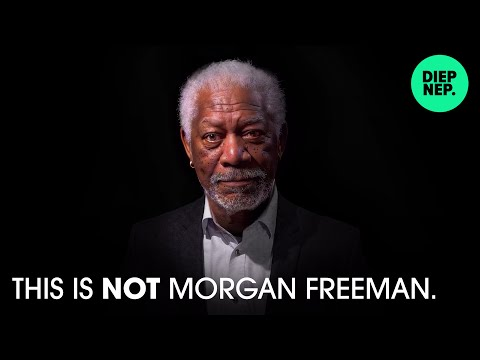

MoviePy - Writing audio in /content/This is not Morgan Freeman  -  A Deepfake Singularity.mp3



chunk:  99%|█████████▊| 1382/1400 [00:01<00:00, 1010.25it/s, now=None]
                                                                      

MoviePy - Done.
Audio conversion successful.


In [ ]:
# UI Elements
# Define the widgets
dropdown = widgets.Dropdown(
    options=[('Select Option', None), ('Upload File', 'upload'), ('YouTube Video', 'youtube')],
    description='Action:'
)
upload_button = widgets.Button(description="Upload File", layout=widgets.Layout(visibility='hidden'))
youtube_input = widgets.Text(placeholder='Enter YouTube URL here', layout=widgets.Layout(visibility='hidden'))
download_button = widgets.Button(description="Download YouTube Video", layout=widgets.Layout(visibility='hidden'))
output = widgets.Output()

# Assign handlers to buttons and dropdown
upload_button.on_click(handle_upload_button_click)
download_button.on_click(handle_download_button_click)
dropdown.observe(on_dropdown_change, names='value')

# Display UI
display(dropdown, upload_button, youtube_input, download_button, output)

# **4. Select the origin spoken language in the media file / YouTube Video**

In [ ]:
from googletrans import LANGUAGES
import ipywidgets as widgets
from IPython.display import display

# Use googletrans LANGUAGES dictionary to get all language options
language_options = {LANGUAGES[code]: code for code in LANGUAGES.keys()}

# Create a dropdown for language selection with English as the default
language_dropdown = widgets.Dropdown(
    options=[(language, code) for language, code in sorted(language_options.items())],
    value='en',  # Set default value to English
    description='Language:',
    disabled=False,
)

# Display the dropdown
display(language_dropdown)


Dropdown(description='Language:', index=21, options=(('afrikaans', 'af'), ('albanian', 'sq'), ('amharic', 'am'…

# **5. Run the transcription and save to TXT / SRT files**

In [ ]:
# global_filename = 'notAlone.wav'

uploaded_filename = global_filename
mp3_filename = convert_to_mp3(uploaded_filename)

mp3_filename

# Split the file into chunks if necessary
chunk_filenames = split_mp3_file(mp3_filename)
chunk_filenames

# Transcribe each chunk with updated progress display
def transcribe_file(filename, progress_bar=None, index=0, total=1):
    try:
        model = whisper.load_model("large")
        result = model.transcribe(filename)
    except Exception as e:
        print(f"Error during transcription of {filename}: {e}")
        result = {'segments': []}  # return an empty result on failure

    if progress_bar:
        completion_percentage = ((index + 1) / total) * 100
        progress_bar.value = completion_percentage
        progress_label.value = f"Transcribing: {completion_percentage:.2f}% completed"

    return result

def split_srt_sentences(srt_file_path, max_words_per_line=6):
    with open(srt_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    new_lines = []
    for line in lines:
        # Check if the line contains text (not a timestamp or sequence number)
        if not line.strip().isdigit() and '-->' not in line:
            words = line.split()
            if len(words) > max_words_per_line:
                # Find the point to split the line
                split_point = max_words_per_line

                # Split the line into two
                line1 = ' '.join(words[:split_point]) + '\n'
                line2 = ' '.join(words[split_point:]) + '\n'
                new_lines.extend([line1, line2])
            else:
                new_lines.append(line)
        else:
            new_lines.append(line)

    # Write the modified content back to the SRT file
    with open(srt_file_path, 'w', encoding='utf-8') as file:
        file.writelines(new_lines)

# Initialize the progress bar and label
progress_bar = IntProgress(min=0, max=100, layout=Layout(width='100%'))  # Max is 100 for percentage
progress_label = Label(value='Starting transcription...')
display(VBox([progress_label, progress_bar]))

# Transcribe each chunk and update the progress bar
all_transcriptions = []
for i, chunk in enumerate(chunk_filenames):
    transcription = transcribe_file(chunk, progress_bar, i, len(chunk_filenames))
    all_transcriptions.append(transcription)
    time.sleep(0.1)  # This allows the UI to update

# Combine the transcriptions
combined_result = combine_transcriptions(all_transcriptions, chunk_filenames)

# Check for translation
selected_language_code = language_dropdown.value

# Assume selected_language_code is defined
try:
    if selected_language_code:
        print('Selected Language Code: ', selected_language_code)
        formatted_srt = translate_and_format_srt(combined_result['segments'], selected_language_code)
        formatted_text = translate_text(format_as_text(combined_result['segments']), selected_language_code)
    else:
        print('Language Code Selection is empty')
        formatted_srt = format_as_srt(combined_result['segments'])
        formatted_text = format_as_text(combined_result['segments'])
except Exception as e:
    print(f"Error during translation: {e}")
    formatted_srt = formatted_text = "Translation failed"

# Save the formatted transcriptions to files
try:
    with open("transcription.srt", "w", encoding='utf-8') as srt_file:
        srt_file.write(formatted_srt)

    with open("transcription.txt", "w", encoding='utf-8') as text_file:
        text_file.write(formatted_text)
except Exception as e:
    print(f"Error writing files: {e}")

# Usage
srt_file_path = "transcription.srt"
split_srt_sentences(srt_file_path)


File size: 1.45 MB
File is smaller than the max chunk size, processing the entire file: /content/This is not Morgan Freeman  -  A Deepfake Singularity.mp3



  0%|                                              | 0.00/2.88G [00:00<?, ?iB/s]
  0%|                                     | 5.83M/2.88G [00:00<00:50, 60.5MiB/s]
  1%|▏                                    | 16.2M/2.88G [00:00<00:34, 88.7MiB/s]
  1%|▎                                    | 25.0M/2.88G [00:00<00:34, 89.9MiB/s]
  1%|▍                                     | 36.8M/2.88G [00:00<00:29, 103MiB/s]
  2%|▌                                     | 46.9M/2.88G [00:00<00:29, 104MiB/s]
  2%|▋                                    | 56.8M/2.88G [00:00<00:35, 86.3MiB/s]
  2%|▊                                    | 66.7M/2.88G [00:00<00:34, 87.2MiB/s]
  3%|▉                                    | 75.3M/2.88G [00:00<00:40, 75.1MiB/s]
  3%|█                                    | 88.7M/2.88G [00:01<00:32, 91.7MiB/s]
  4%|█▎                                     | 104M/2.88G [00:01<00:27, 109MiB/s]
  4%|█▍                                    | 115M/2.88G [00:01<00:29, 99.6MiB/s]
  4%|█▌                    

Selected Language Code:  en


# **6. Optional: Translate the TXT / SRT to another language**

In [ ]:
file_list = get_file_list("/content")

# Dropdown for file selection
file_dropdown = widgets.Dropdown(
    options=file_list,
    description='Select file:',
    disabled=False,
)
display(file_dropdown)

# Dropdown for language selection
language_options = {LANGUAGES[code]: code for code in LANGUAGES.keys()}
language_dropdown = widgets.Dropdown(
    options=[(language, code) for language, code in sorted(language_options.items())],
    value='en',
    description='Translate to:',
    disabled=False,
)
display(language_dropdown)

# Button for triggering translation
translate_button = widgets.Button(description="Translate Files")
display(translate_button)

# Progress bar for translation
translate_progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=2,  # Assuming two files to translate
    description='Translating:',
    bar_style='',  # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'blue'},
    orientation='horizontal'
)
display(translate_progress_bar)

# Link the button click event to the handler function
translate_button.on_click(on_translate_button_clicked)


Dropdown(description='Select file:', options=('translated_he_transcription.txt', 'translated_he_transcription.…

Dropdown(description='Translate to:', index=21, options=(('afrikaans', 'af'), ('albanian', 'sq'), ('amharic', …

Button(description='Translate Files', style=ButtonStyle())

IntProgress(value=0, description='Translating:', max=2, style=ProgressStyle(bar_color='blue'))

# **7. Download the TXT / SRT files**

In [ ]:
import os
from google.colab import files
import ipywidgets as widgets

# Function to get a list of all files in the /content directory
def get_files(directory):
    return [file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]

# Get list of files
all_files = get_files("/content")

# Dropdown for file selection
file_download_dropdown = widgets.Dropdown(
    options=all_files,
    description='Select file:',
    disabled=False,
)
display(file_download_dropdown)

# Button for triggering download
download_button = widgets.Button(description="Download File")
display(download_button)

def on_download_button_clicked(b):
    selected_file_path = file_download_dropdown.value  # Get the selected file from the dropdown
    if selected_file_path:
        files.download("/content/" + selected_file_path)  # Download the file

# Link the button click event to the handler function
download_button.on_click(on_download_button_clicked)


Dropdown(description='Select file:', options=('translated_he_transcription.txt', 'translated_he_transcription.…

Button(description='Download File', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>